# Ch.1. Introduction to Virtual Sensing and Input Reconstruction
*Created: M.M., 23.5.2024*

In [1]:
import numpy as np
from scipy.linalg import expm
from numpy.linalg import matrix_power
from scipy import signal
import matplotlib.pyplot as plt

## 1.1. Contineous linear time-invarient (LTI) systems
A linear time-invariant (LTI) system is a collection of first-order linear ordinary differential equations that can be written on a state-space form

\begin{align}
\dot{x}(t) &= Ax(t) + Bu(t)\\
y(t) &= Cx(t),
\end{align}

where $x(k)$ is called the state vector, $u(k)$ the input vector, and $y(k)$ the output or measurement vector. The system is called *linear* because is is a linear operator (meaning that $y = G(u_1+u_2) = Gu_1 + Gu_2$), not to be confused with a line or a plane. Time invariant means that the parameters $A,B,C$ does not change with time.

### 1.1.1. Example LTI system
One of the simplest LTI system one can think of might be the sliding cart

![cart](https://raw.githubusercontent.com/mmanngard/VirtualSensors/a079e1fe01148c749caa5fd2745499da8c11a760/notebooks/cart.drawio.svg)

where $\mu$ is a friction coefficient, and $F$ is a force applied to the cart.

It is surprising how often this simple school book example can be used to approximate real-world systems! Newton's laws of motion with (net force $F$ equals mass $m$ times acceleration $\ddot{x}$) gives
\begin{equation*}
m\ddot{x} = F - \mu\dot{x},
\end{equation*}
which is a second-order differential equation. This can be rewritten as a set of first-order differential equation by defining new states:
- Position: $x_1=x$
- Velocity: $x_2=\dot{x}$,

and input:

- Net force: $u=F$.

Rewriting the system gives

$$
\begin{bmatrix}
\dot{x}_1\\
\dot{x}_2
\end{bmatrix}
=
\begin{bmatrix}
0 &1\\
0 &-\mu/m
\end{bmatrix}
\begin{bmatrix}
x_1\\
x_2
\end{bmatrix}
+
\begin{bmatrix}
0\\1/m
\end{bmatrix}
u.
$$

Suppose we measure the velocity of the cart, we have
$$
y = \begin{bmatrix}
0 &1
\end{bmatrix}
\begin{bmatrix}
x_1\\
x_2
\end{bmatrix}
+v
$$
where $v$ is measurement noise. This is exacly of the form (1)-(2).

### 1.1.2. Simulate an LTI systems

Text(0.5, 0, 'time (s)')

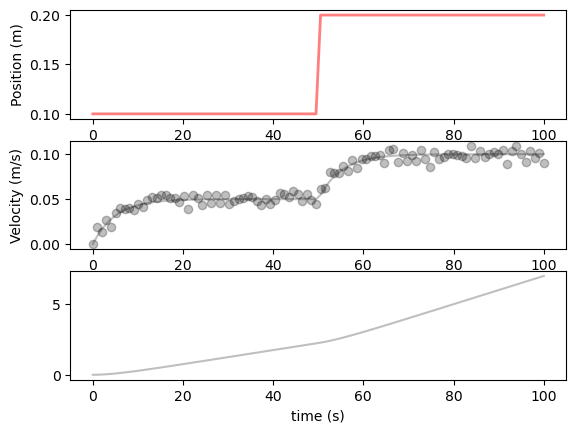

In [2]:
# parameters
mu = 2 #friction coefficient
m = 10 #mass

# system matrices
A = np.array([[0, 1],[0, -mu/m]])
B = np.array([[0],[1/m]])
C = np.array([[0, 1]])

# simulaiton parameters
N = 100 #number of time steps
t = np.linspace(0,100,N) #time points
#input signal (step)
u = np.array([])
for i in range(N):
    if i<N/2:
        u = np.append(u,.1)
    else:
        u = np.append(u,.2)
u0 = u

# measurement noise
v = 0.005*np.random.normal(0,1,N)

# simulate
sys = signal.StateSpace(A,B,C)
tout, y, xout = signal.lsim(sys, U=u, T=t)
# add noise
y += v

y_no_outlier = y.copy() #save this for later

# plot result
fig, axs = plt.subplots(3)
axs[0].plot(t, u,'r', alpha=0.5, linewidth=2, label='input')
axs[0].set_ylabel('Force (N)')
axs[1].plot(tout,xout[:,1], color='k', alpha=0.25)
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None)
axs[1].set_ylabel('Velocity (m/s)')
axs[2].plot(tout,xout[:,0], color='k', alpha=0.25)
axs[0].set_ylabel('Position (m)')
plt.xlabel('time (s)')



---
## 1.2. Reconstructing unknown input signals
Consider now the previous cart example where we have collecter measurements $y(0), y(1),...,(N-1)$ and want to reconstruct the force applied to it. Using the `c2d()` function we can convert the continuous-time model to a discrete-time state space model
\begin{align*}
x(k+1) &= Ax(k) + Bu(k)\\
y(k) &= Cx(k) + v(k).
\end{align*}
Note that the $A,B,C$ matrices are now different from in the previous section and $y(k)$ is a measurement obtaind at the $k$ th time instance.

In [3]:
def c2d(A,B,Ts):
    """
    C2D computes a discrete-time model of a system (A_c,B_c) with sample time T_s.
    The function returns matrices A,B of the discrete-time system.
    """
    m,n = A.shape
    m,nb = B.shape

    s = np.concatenate([A,B], axis=1)
    s = np.concatenate( [s, np.zeros( (nb,n+nb) )],axis=0 )
    S = expm(s*Ts)
    Ad = S[0:n,0:n]
    Bd = S[0:n,n:n+nb+1]
    return Ad, Bd



### 1.2.1. The data equation
After substituting the first equation int the second equation repeated times, and after some algebraic manipulations, we get the so called **data equation**

$$
\begin{aligned}
    y(0) &= Cx(0) + v(0),\\
    y(1) &= CAx(0) + Bu(0) + v(1),\\
    \vdots &\\
    y(n) &= CA^{n}x(0) + \sum_{k=0}^{n-1} CA^{k}u(n-k-1) + v(n),\\
    \vdots &
\end{aligned}
$$

or in matrix form

$$
\underbrace{
\begin{bmatrix}
y(0)\\
y(1)\\
y(2)\\
\vdots\\
y(N-1)
\end{bmatrix}
}_{y}
=
\underbrace{
\begin{bmatrix}
C\\
CA\\
CA^2\\
\vdots\\
CA^{N-1}
\end{bmatrix}
}_{\mathcal{O}}
x(0)
+
\underbrace{
\begin{bmatrix}
0 &0 &\cdots &0\\
CB &0 &\cdots &0\\
CAB &CB &\cdots &0\\
\vdots &\vdots &\ddots &\vdots\\
CA^{N-2}B &CA^{N-3}B &\cdots &0
\end{bmatrix}
}_{\Gamma}
\underbrace{
\begin{bmatrix}
u(0)\\u(1)\\u(2)\\ \vdots\\ u(N-1)
\end{bmatrix}
}_{u}
+
\underbrace{
\begin{bmatrix}
v(0)\\v(1)\\v(2)\\ \vdots\\ v(N-1)
\end{bmatrix}
}_{v}.
$$

The section on *subspace system identification* in the book [Filtering and System Identification](https://books.google.fi/books?hl=sv&lr=&id=6Ne76uYOlVwC&oi=fnd&pg=PR11&dq=verhaegen+least+squares+approach&ots=H7GzIs_Rab&sig=PfKVrPuYiSlWfjI3_tymLiI1-U8&redir_esc=y#v=onepage&q=verhaegen%20least%20squares%20approach&f=false) by Verhaegen, Michel, and Vincent Verdult explains this well (*read*: check that I havent done any mistakes here).

* **Note**: This equation is commonly occuring in the control-theory and system identification litterature and is often referred to as the *data equation*. Here I have used the standard notation $\mathcal{O}$ for the extended observability matrix (which is used for determining stability of a system), and $\Gamma$ for the impulse response matrix. The impulse response of the system is $h(k) = CA^{k-1}B$. In [(Ikonen et al.,2015)](https://www.sciencedirect.com/science/article/pii/S0165232X14002274), the non-standard notation  $g(k)=h(k)$, $R=y$, $G = \Gamma$, and $M = u$ was used instead.


In [4]:
def obsv(A, C, n):
    '''
    Create the extended observability matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    O : numpy.ndarray, shape(n, number of state variables)
        The extended observability matrix
    '''
    O = C
    for k in range(1, n):
        O = np.vstack((O, C @ np.linalg.matrix_power(A, k)))

    return O

# I got some errors with your function, so I modified the solution I found from stackexchange:
# https://scicomp.stackexchange.com/questions/33239/is-there-an-efficient-way-to-form-this-block-matrix-with-numpy-or-scipy

def Gamma(A,B,C,N):
    '''
    Create the impulse response matrix used in the data equation.

    Parameters:

    A : numpy.ndarray
        The state matrix of the state-space system
    B : numpy.ndarray
        The input matrix of the state-space system
    C : numpy.ndarray
        The observation matrix of the state-space system
    n : float
        number of measurements

    Returns:

    gamma : numpy.ndarray, shape(n*number of state variables, n*number of state variables)
        The impulse response matrix
    '''
    mat_list = []
    n = (C@B).shape[0]
    m = (C@B).shape[1]
    for i in range(N): # generate row
        tmp = []
        for j in range(N): # loop through A^j*B
            if j <= i:
                tmp.append(C@np.linalg.matrix_power(A,i-j)@B)
        if i < N-1:
            tmp.append(np.zeros((n, m*(N-1-i))))
        mat_list.append(tmp)
        G = np.block(mat_list)
        #add zero row and column
        n,m = (C@B).shape
        ng,mg = G.shape
        G = np.append(np.zeros((n,mg)),G,axis=0)
        G = np.append(G,np.zeros((n+ng,m)),axis=1)
    return G

### 1.2.3. The input reconstruction problems
Assume for simplicity that we know the initial state $x(0)=0$, we have
$$
y = \Gamma u + v
$$
and we would like to find the vector $u$ that minimizes the error $y - \Gamma u$. The reconstruction problem can thus be solved as a **linear least-squares-type problem**. Typically, however, to ensure that the problem is well-posed and to reduce the sensitivity to measurement noise, a **regularized least-squares problem** is solved instead.

$$
\underset{u}{\mathrm{minimize}} || y - \Gamma u ||^2_2 + R(u),
$$

where $R(u)$ is a regularization function. Deciding what function $R$ to use is an engineering problem, and the choice depends completely on experience and the prior knowledge of the signal $u$. Various types of regularization functions were proposed in ([Urho Hakonen, 2023](https://aaltodoc.aalto.fi/items/2cb62532-ea16-48b2-ace1-0a7bfcd4f947)), for example
- **Tikhonov regularization** $R(u)=\|u\|_2^2$ (also called Ridge regression). Tikhonov-regularization seems to be a reasonable choice when $u$ is a zero-mean stationary-stochastic signal.
- **Hodrick-Prescott trend filtering** $R(u)=\|\Delta^2 u\|_2^2$ (enforces smoothness on $u$). A natural choice for estimation of physical signals such as force and moment since such tend to be smooth signals in nature.

#### Tikhonov regularization
Consider the Tikhonov regularized input-reconstruction problem minimizing the cost function.
$$
J(u) = || y - \Gamma u ||^2_2 + \lambda||u||_2^2,
$$
Where $\lambda$ is a regularization parameter. The Rikhonov regularized problem has a solution
$$
\hat{u} = ( \Gamma^T\Gamma + \lambda I )^{-1}\Gamma^T y.
$$
*This can be verified by noting that $J$ is a quadratic function which has its minimum at $\frac{\mathrm{d}J}{du}=0$.*

Text(0.5, 0, 'time (s)')

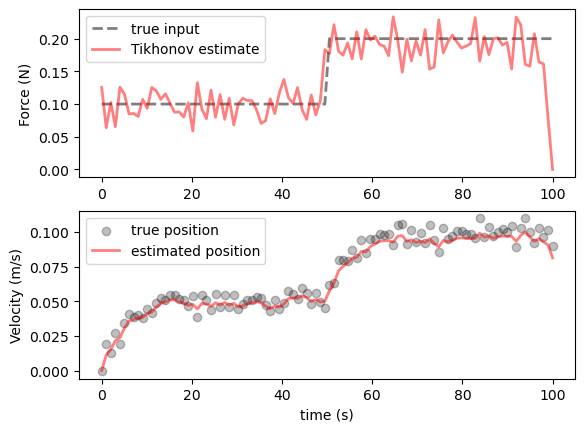

In [5]:
# discrete-time system
A, B = c2d(sys.A,sys.B,1)

# Compute Gamma
G = Gamma(A,B,C,N-1)

lam = 0.01

# Estimate u
uhat = np.linalg.pinv(G.T@G + lam*np.eye(N))@G.T@np.reshape(y,(N,1))

# plot results
fig, axs = plt.subplots(2)
axs[0].plot(t, u,'k--', alpha=0.5, linewidth=2, label='true input')
axs[0].plot(t, uhat,'r', alpha=0.5, linewidth=2, label='Tikhonov estimate')
axs[0].set_ylabel('Force (N)')
axs[0].legend()
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None, label='true position')
axs[1].plot(tout, G @ uhat,'r', alpha=0.5, linewidth=2, label='estimated position')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
plt.xlabel('time (s)')

#### Hodrick-Prescott trend filtering
In H-P filtering, the regularization term minimizes the $\ell_2$ norm of the second difference $u(k-1) - 2u(k) + u(k+1)$. If the second difference of a signal is small, the signal is smooth. The H-P trend filtering input reconstruction problem is
$$
\underset{u}{\mathrm{minimize}}~ || y - \Gamma u ||^2_2 + \lambda \| \Delta_2 u \|_2^2  .
$$
where
\begin{equation}
    \Delta_2 =
    \begin{bmatrix}
    1 &-2 &1      &       &       & \\
      &1  &-2     &1      &       & \\
      &   &\ddots &\ddots &\ddots & \\
      &   &       &1      &-2     &1
    \end{bmatrix}
\end{equation}
and has the solution
$$
\hat{u} = ( \Gamma^2\Gamma + \lambda\Delta_2^{T}\Delta_2 )^{-1}\Gamma^Ty
$$



Text(0.5, 0, 'time (s)')

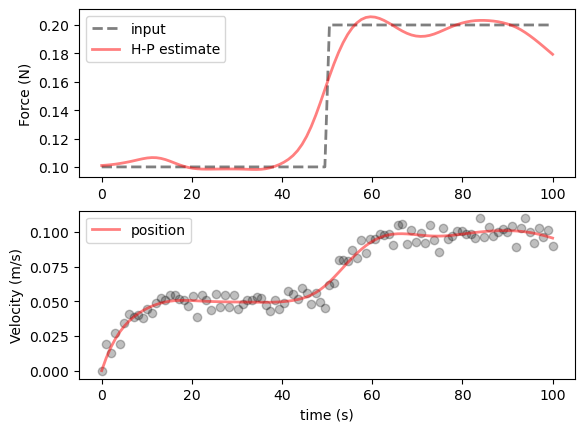

In [6]:
Delta = np.eye(N,k=-1) - 2*np.eye(N) + np.eye(N,k=1)
Delta[0,:] = 0
Delta[-1,:] = 0

#H-P estimate
lam = 10
uhat_HP = np.linalg.inv(G.T@G + lam*Delta.T@Delta)@G.T@np.reshape(y,(N,1))

# plot results
fig, axs = plt.subplots(2)
axs[0].plot(t, u,'k--', alpha=0.5, linewidth=2, label='input')
axs[0].plot(t, uhat_HP,'r', alpha=0.5, linewidth=2, label='H-P estimate')
axs[0].set_ylabel('Force (N)')
axs[0].legend()
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None)
axs[1].plot(tout, G @ uhat_HP,'r', alpha=0.5, linewidth=2, label='position')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
plt.xlabel('time (s)')

#### H-P filtering with additional constraints
In this section, we illustrate how constraints on the input signals can be added and solved as a convex optimization problem with `cvxpy`. Assume we want to enforce bound on the estimated output $\hat{y}(k) = \Gamma \hat{u}$, i.e.,
$$
| y - \Gamma \hat{u} | \leq \varepsilon,
$$
where $\varepsilon > 0$. This results in the convex optimizaiton problem
\begin{align*}
    &\underset{u}{\mathrm{minimize}}~ || y - \Gamma u ||^2_2 + \lambda \| \Delta_2 u \|_2^2 \\
    &\text{subject~to} \\
    &|y - \Gamma \hat{u}| \leq \varepsilon 
\end{align*}

The follopwing example code shows how the problem is implemented in `cvxpy`.

Text(0.5, 0, 'time (s)')

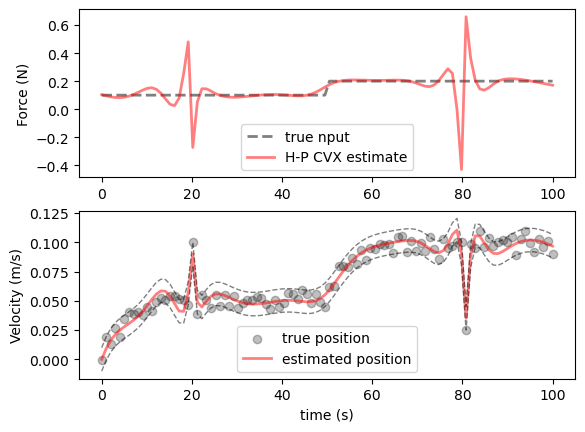

In [7]:
import cvxpy as cp

#outliers
y[20] = 0.1
y[80] = 0.025

# create bounds
eps = 0.01
lam = 10

# define optimization variables
uhat_cvx = cp.Variable(N, complex=False)

# define objective function
objective = cp.Minimize(cp.sum_squares(y - G @ uhat_cvx) + lam * cp.sum_squares(Delta @ uhat_cvx))

# define constraints
constraints = [
    cp.abs( y - G @ uhat_cvx ) <= eps
]

# define problem
prob = cp.Problem(objective, constraints)

# solve optimizaiton problem
prob.solve()


# plot results
fig, axs = plt.subplots(2)
axs[0].plot(t, u,'k--', alpha=0.5, linewidth=2, label='true nput')
axs[0].plot(t, uhat_cvx.value,'r', alpha=0.5, linewidth=2, label='H-P CVX estimate')
axs[0].set_ylabel('Force (N)')
axs[0].legend()
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None, label='true position')
axs[1].plot(tout, G @ uhat_cvx.value,'r', alpha=0.5, linewidth=2, label='estimated position')
axs[1].plot(tout, G @ uhat_cvx.value + eps,'k--', alpha=0.5, linewidth=1)
axs[1].plot(tout, G @ uhat_cvx.value - eps,'k--', alpha=0.5, linewidth=1)
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
plt.xlabel('time (s)')


#### Support Vector Reconstruction
An issue with the previous methos is the sensitivity to outliers. To mitigate this, we consider the support-vector formulation:

\begin{align*}
    &\underset{u, \xi, \xi^\ast }{\mathrm{minimize}}~ \| \Delta_2 u \|_2^2 + \lambda\|\xi + \xi^\ast\|_1\\
    &\text{subject~to} \\
    &y - \Gamma u \leq \varepsilon + \xi\\
    &\Gamma u - y \leq \varepsilon + \xi^\ast\\
    &\xi, \xi^\ast \geq 0
\end{align*}

where $\xi_k$ and $\xi_k^\ast$ are slack variables that quantify the deviation of the predicted values from the actual measurements $y(k)$. The inclusion of these slack variables in the support vector framework allows the model to handle outliers that surpass the $\varepsilon$-insensitive zone.

The regularization term $\lambda\|\xi + \xi^\ast\|_1$ induces sparsity in the slack variables $\xi$ and $\xi^\ast$, under the assumption that the number of outliers is sparse relative to the total number of observations.

Text(0.5, 0, 'time (s)')

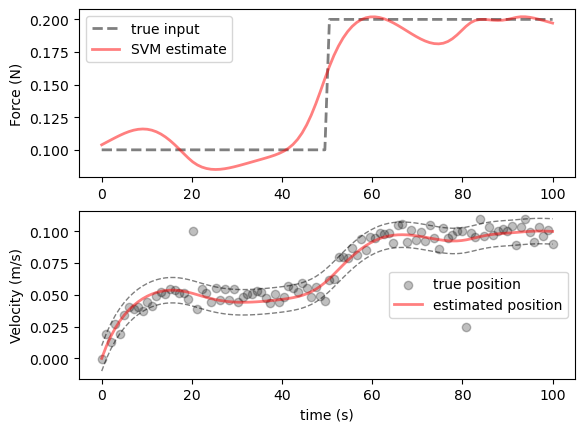

In [8]:
#outliers
y[20] = 0.1
y[80] = 0.025 

# create bounds
lam = 0.01

# define optimization variables
uhat_svm = cp.Variable(N, complex=False)
xi = cp.Variable(N, complex=False)
xi_ast = cp.Variable(N, complex=False)


# define objective function
objective = cp.Minimize( cp.sum_squares(Delta @ uhat_svm) + lam*cp.norm1(xi + xi_ast) )

# define constraints
constraints = [
    y - G @ uhat_svm <= eps + xi,
    G @ uhat_svm - y <= eps + xi_ast,
    xi >= 0,
    xi_ast >= 0
]

# define problem
prob = cp.Problem(objective, constraints)

# solve optimizaiton problem
prob.solve()

# plot results
fig, axs = plt.subplots(2)
axs[0].plot(t, u,'k--', alpha=0.5, linewidth=2, label='true input')
axs[0].plot(t, uhat_svm.value,'r', alpha=0.5, linewidth=2, label='SVM estimate')
axs[0].set_ylabel('Force (N)')
axs[0].legend()
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None, label='true position')
axs[1].plot(tout, G @ uhat_svm.value,'r', alpha=0.5, linewidth=2, label='estimated position')
axs[1].plot(tout, G @ uhat_svm.value + eps,'k--', alpha=0.5, linewidth=1)
axs[1].plot(tout, G @ uhat_svm.value - eps,'k--', alpha=0.5, linewidth=1)
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
plt.xlabel('time (s)')



## 1.3. Input and state estimation by convex optimization

So far, we have only considered batch estimation of unknown inputs and have not addressed the challenge of implementing simultaneous input and state estimation in real-time. In this section, we focus on formulating the input and state estimation problem for real-time implementation. Instead of using a batch-processing framework, we propose a filter-like convex optimization approach that can be implemented efficiently online.

### 1.3.1. The Kalman filter as a convex optimization problem
Let’s start by introducing some new notation:
- $\hat{x}_{k|k-1}$ denotes "the estimate of the state $x_k$ at time step $k$ given information up to time step $k-1$."
- $\hat{x}_{k|k}$ represents "the estimate of the state $x_k$ at time step $k$ given all available information up to and including time step $k$."

Expressing the Kalman filter as a convex optimization problem offers a key benefit: it provides a flexible framework to incorporate additional constraints that may arise in practice, such as state or input bounds, which the classical Kalman filter does not account for. For a known input $u_k$, the following optimization problem gives the same solution as a Kalman filter but formulated as a convex optimization problem ([Boyd, 2010](https://d1wqtxts1xzle7.cloudfront.net/35064125/sig_proc_mag-libre.pdf?1412875626=&response-content-disposition=inline%3B+filename%3DReal_Time_Convex_Optimization_in_Signal.pdf&Expires=1725696009&Signature=gRfpB18eDaSbCOny6BFtT7lNoFgoNDz6qwNLUQm9SA2AXReuqiJNbcR2AY514s8finlc5uHgKtZYlaQWgweOCJUUH3dpwp4r-YqyLAvC~90Sx35m9cXnUFxaFkgUSwUdbOOILV6oN2TC~mImvAQ3Amx7C1eqygqcX1rmszekUQpiMXLGFRzKgKA39JV2Kd59gjeXjX99Lvb60~Z5UxF750dbyxjU3aB7rUN-3PGF0ZjZMUcT~CL0h-YuWfkoBjd57YYQXrDiMmh5tTNnA3WsOuV87~vLm~fRDIUoy-TEV~sJWhSM*I99N3hU1G2lm~iXOx6zJHxyYTAc1PGh4rSP00w__&Key-Pair-Id=APKAJLOHF5GGSLRBV4ZA)):

\begin{align*}
    &\underset{x}{\mathrm{minimize}}\quad v_k^TQ_v^{-1}v_k + w_k^TQ_x^{-1}w_k \\
    &\text{subject~to} \\
    &\hat{x}_{k|k-1} = A\hat{x}_{k-1|k-1} + Bu_{k-1} \\
    &v_k = y_k - Cx \\
    &w_k = \hat{x}_{k|k-1} - x
\end{align*}

In this formulation:
- $v_k$ is the measurement error, with covariance $Q_v$.
- $w_k$ is the state prediction error, with covariance $Q_x$.


The problem minimizes the sum of the weighted norms of these two errors, balancing state prediction accuracy and measurement fit. Given the solution $x$, the state estimate is simply $\hat{x}_{k|k} = x$.

By substituting the constraints into the objective function, the problem becomes a unconstrained quadratic program. The optimal solution to this (should) be equivalent to the solution of the Kalman filter in the steady-state. **Verify this!**

<div style="border:1px solid white; padding:10px">
The problem minimizes a quadratic form 

$$
J(x) = (y-Cx)^T Q_v^{-1}(y-Cx) + (A\hat{x}_{k|k-1} + Bu - x)^TQ_w^{-1}(A\hat{x}_{k|k-1} + Bu - x).
$$

Since $J(x)$ the minimum at $\frac{\mathrm{d}J}{\mathrm{d}x} = 0$ and

$$
\frac{\mathrm{d}J}{\mathrm{d}x} = 2(C^TQ_v^{-1}C + Q_w^{-1})x - 2( C^TQ_v^{-1}y + Q_w^{-1}(A\hat{x}_{k|k-1} + Bu) ) = 0,
$$

the numeric solution is

$$
x = ( C^TQ_v^{-1}C + Q_w^{-1} )^{-1} \left( C^TQ_v^{-1}y + Q_w^{-1}( A\hat{x}_{k|k-1} + Bu ) \right)
$$

</div>

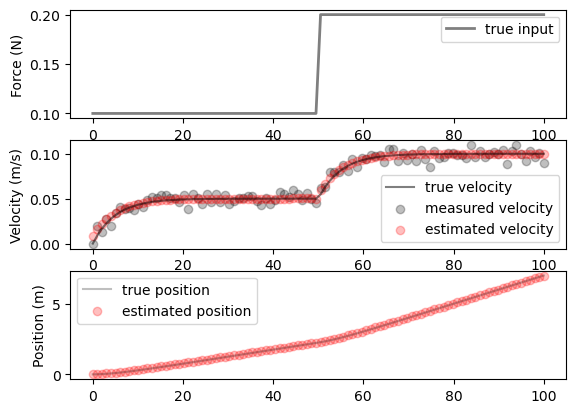

In [10]:
y = y_no_outlier
u = u0

n_states = 2
n_inputs = 1
n_outputs = 1

# define optimization variables
#u = cp.Variable(N, complex=False)
x = cp.Variable((n_states,1), complex=False)

# covariance matrices
Q_v = 0.005*np.eye(n_outputs)
Q_w = 0.0001*np.eye(n_states)
# compute inverces
Q_v_inv = np.linalg.inv(Q_v)
Q_w_inv = np.linalg.inv(Q_w)

def cvx_KF(y, xhat, u, Q_v_inv, Q_w_inv):
    '''Kalman-filter formualtion as a convex optimization problem where
    y: The mesuremente vector y_k
    xhat: Is the state estimate from previous iteration \hat{x}_{k-1|k-1}
    u: The input signal u_{k-1}
    Q_v, Q_w: Are the measurement error and state prediction error covariance matrices.

    '''
    # define objective function
    # NOTE THAT scalar multiplication B*u IS USED HERE AND NOT B@U. REMEMBER TO CHANGE THIS IF u IS NOT SCALAR !!!
    objective = cp.Minimize( cp.quad_form( y - C@x, Q_v_inv ) + cp.quad_form( A@xhat + B*u - x , Q_w_inv ) )

    # define constraints
    constraints = []

    # define problem
    prob = cp.Problem(objective, constraints)

    # solve optimizaiton problem
    prob.solve()
    return x.value

#K = np.linalg.inv( C.T@Q_v_inv@C + Q_w_inv )

xhat = np.array([[0], [0]])
#xhat2 = xhat.copy()
x_est = xhat
for k, y_k in enumerate(y_no_outlier):
    xhat = cvx_KF(y_k, xhat, np.array(u[k]), Q_v_inv, Q_w_inv)
    #xhat2 = K @ ( C.T @ Q_v_inv * y_k + Q_w_inv @ ( A @ xhat2 + B @ np.array(u[k]).reshape(-1,1) ) )
    x_est = np.append(x_est, xhat)
    #x_est2 = np.append(x_est, xhat2)
x_est = np.reshape(x_est, (-1,2))
#x_est2 = np.reshape(x_est, (-1,2))

# plot result
fig, axs = plt.subplots(3)
axs[0].plot(t, u,'k', alpha=0.5, linewidth=2, label='true input')
axs[0].set_ylabel('Force (N)')
axs[0].legend()
axs[1].plot(tout,xout[:,1], color='k', alpha=0.5, label='true velocity')
axs[1].scatter(tout, y_no_outlier, alpha=0.25, color='k', edgecolor=None, label='measured velocity')
axs[1].scatter(t, x_est[1:,1], alpha=0.25, color='r', edgecolor=None, label='estimated velocity')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
axs[2].plot(tout, xout[:,0], color='k', alpha=0.25, label='true position')
axs[2].scatter(t, x_est[1:,0], alpha=0.25, color='r', edgecolor=None, label='estimated position')
axs[2].set_ylabel('Position (m)')
axs[2].legend()


### 1.3.2. Simulatneous input and state estimation as a convex optmization problem

Observe that $\hat{x}_{k|k-1}$ depends linearly on the input $u_k$ in the KF problem above. Thus, we can formulate the simultaneous input and state estimation problem as a convex optimization problem:

\begin{align*}
    &\underset{x,~u}{\mathrm{minimize}} \quad v_k^T Q_v^{-1} v_k + w_k^T Q_x^{-1} w_k + u^T Q_u^{-1} u \\
    &\text{subject to} \\
    &\hat{x}_{k|k-1} = A\hat{x}_{k-1|k-1} + Bu \\
    &v_k = y_k - Cx \\
    &w_k = \hat{x}_{k|k-1} - x
\end{align*}

where:
- The state estimate is $\hat{x}_{k|k} = x$
- The input estimate is $\hat{u}_{k-1|k} = u$ and $Q_u$ is the covariance matrix of $u$.

This formulation indirectly makes the assumption that $u$ belongs to a class of stationary stochastic signals. To extend this to quasi-stationary input signals, one could include models of how the input signal propagates in time, for example, by introducing a random-walk model $u_k = u_{k-1} + v_u$, driven by noise $v_u$. See, e.g., ([Manngård, 2023](https://www.sciencedirect.com/science/article/pii/S0888327022001480)).

**Remark:** Since $y_k$ does not depend on $u_k$, the best we can expect to do without a model of how $u_k$ propagates in time is to estimate $\hat{u}_{k-1|k}$.


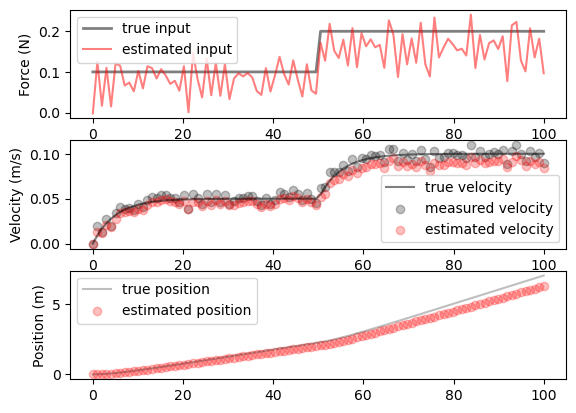

In [11]:
y = y_no_outlier

n_states = 2
n_inputs = 1
n_outputs = 1

# define optimization variables
x = cp.Variable((n_states,1), complex=False)
u = cp.Variable((n_inputs,1), complex=False)

# covariance matrices
Q_v = 0.005*np.eye(n_outputs)
Q_w = 0.001*np.eye(n_states)
Q_u = 1*np.eye(n_inputs)
# compute inverces
Q_v_inv = np.linalg.inv(Q_v)
Q_w_inv = np.linalg.inv(Q_w)
Q_u_inv = np.linalg.inv(Q_u)

def cvx_SISE(y_k, xhat, Q_v_inv, Q_w_inv, Q_u_inv):
    '''Simultaneous input and state estimation (SISE) formualtion as a convex optimization problem where
    y: The mesuremente vector y_k
    xhat: Is the state estimate from previous iteration \hat{x}_{k-1|k-1}
    u: The input signal u_{k-1}
    Q_v, Q_w: Are the measurement error and state prediction error covariance matrices.

    '''
    # define objective function
    objective = cp.Minimize( cp.quad_form( y_k - C@x, Q_v_inv ) + cp.quad_form( A@xhat + B@u - x , Q_w_inv ) + cp.quad_form( u , Q_u_inv ))

    # define constraints
    constraints = []

    # define problem
    prob = cp.Problem(objective, constraints)

    # solve optimizaiton problem
    prob.solve()
    return x.value, u.value

xhat = np.array([[0], [0]])
x_est = xhat
u_est = np.array([])
for k, y_k in enumerate(y):
    xhat, uhat = cvx_SISE(y_k, xhat, Q_v_inv, Q_w_inv, Q_u_inv)
    x_est = np.append(x_est, xhat)
    u_est = np.append(u_est, uhat)
x_est = np.reshape(x_est, (-1,2))

# plot result
fig, axs = plt.subplots(3)
#axs[0].plot(t, u,'k', alpha=0.5, linewidth=2, label='true input')
axs[0].plot(t, u0,'k', alpha=0.5, linewidth=2, label='true input')
axs[0].plot(tout,u_est,color='r', alpha=0.5, label='estimated input')
axs[0].set_ylabel('Force (N)')
axs[0].legend()
axs[1].plot(tout, xout[:,1], color='k', alpha=0.5, label='true velocity')
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None, label='measured velocity')
axs[1].scatter(t, x_est[1:,1], alpha=0.25, color='r', edgecolor=None, label='estimated velocity')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
axs[2].plot(tout, xout[:,0], color='k', alpha=0.25, label='true position')
axs[2].scatter(t, x_est[1:,0], alpha=0.25, color='r', edgecolor=None, label='estimated position')
axs[2].set_ylabel('Position (m)')
axs[2].legend()


#### Random-walk input model
Note that in this example, since $u$ is a step function, which is not stationary stochastic, we struggle to tune the parameters to obtain both good estimates of $u$ and $x$. Instead, let’s introduce a random-walk input model:

$$u_k = u_{k-1} + v_{\mathrm{u},k},$$

where $v_{\mathrm{u},k}$ is d white noise with covariance $Q_u$. This results in the following optimization problem:

\begin{align*}
    &\underset{x,~u}{\mathrm{minimize}} \quad v_k^T Q_v^{-1} v_k + w_k^T Q_x^{-1} w_k + v_{\mathrm{u},k}^T Q_u^{-1} v_{\mathrm{u},k} \\
    &\text{subject to} \\
    &\hat{x}_{k|k-1} = A\hat{x}_{k-1|k-1} + Bu \\
    &v_k = y_k - Cx \\
    &w_k = \hat{x}_{k|k-1} - x \\
    &u = \hat{u}_{k-2|k-1} + v_{\mathrm{u},k}.
\end{align*}

Again, this can be rewritten as an unconstrained quadratic programming problem. However, in the example below, we chose to keep the input model as a constraint to make it easier in the future to modify the model.


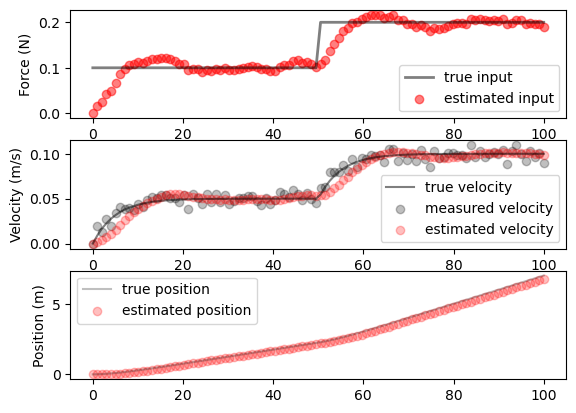

In [28]:
y = y_no_outlier
#y[20] = 0.1
#y[80] = 0.025 
u = u0

n_states = 2
n_inputs = 1
n_outputs = 1

# define optimization variables
#u = cp.Variable(N, complex=False)
x = cp.Variable((n_states,1), complex=False)
u = cp.Variable((n_inputs,1), complex=False)
v_u = cp.Variable((n_inputs,1), complex=False)

# covariance matrices
Q_v = 0.005*np.eye(n_outputs)
Q_w = 0.0001*np.eye(n_states)
Q_u = 0.05*np.eye(n_inputs)

# compute inverces
Q_v_inv = np.linalg.inv(Q_v)
Q_w_inv = np.linalg.inv(Q_w)
Q_u_inv = np.linalg.inv(Q_u)

def cvx_SISE(y, xhat, uhat, Q_v_inv, Q_w_inv, Q_u_inv):
    '''Simultaneous input and state estimation (SISE) formualtion as a convex optimization problem where
    y: The mesuremente vector y_k
    xhat: Is the state estimate from previous iteration \hat{x}_{k-1|k-1}
    u: The input signal u_{k-1}
    Q_v, Q_w: Are the measurement error and state prediction error covariance matrices.

    '''
    # define objective function
    objective = cp.Minimize( cp.quad_form( y - C@x, Q_v_inv ) + cp.quad_form( A@xhat + B@u - x , Q_w_inv ) + cp.quad_form( v_u , Q_u_inv ))

    # define constraints
    constraints = [
        v_u == u - uhat
    ]

    # define problem
    prob = cp.Problem(objective, constraints)

    # solve optimizaiton problem
    prob.solve()
    return x.value, u.value

xhat = np.array([[0], [0]])
uhat = 0
x_est = xhat
u_est = np.array([])
for k, y_k in enumerate(y):
    xhat, uhat = cvx_SISE(y_k, xhat, uhat, Q_v_inv, Q_w_inv, Q_u_inv)
    x_est = np.append(x_est, xhat)
    u_est = np.append(u_est, uhat)
x_est = np.reshape(x_est, (-1,2))

# plot result
fig, axs = plt.subplots(3)
#axs[0].plot(t, u,'k', alpha=0.5, linewidth=2, label='true input')
axs[0].plot(t, u0,'k', alpha=0.5, linewidth=2, label='true input')
axs[0].scatter(tout,u_est,color='r', alpha=0.5, label='estimated input')
axs[0].set_ylabel('Force (N)')
axs[0].legend()
axs[1].plot(tout, xout[:,1], color='k', alpha=0.5, label='true velocity')
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None, label='measured velocity')
axs[1].scatter(t, x_est[1:,1], alpha=0.25, color='r', edgecolor=None, label='estimated velocity')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
axs[2].plot(tout, xout[:,0], color='k', alpha=0.25, label='true position')
axs[2].scatter(t, x_est[1:,0], alpha=0.25, color='r', edgecolor=None, label='estimated position')
axs[2].set_ylabel('Position (m)')
axs[2].legend()


### 1.3.3. Trend filtering formulation
Let's return to the trend filtering formulation which constrains the second difference of the input estimated. We constrain the backwards second difference
$$
\Delta^2_k = \hat{u}_{k-1|k} - 2\hat{u}_{k-2|k-1} + \hat{u}_{k-3|k-2}
$$

an formulate the following trend filtering problem

\begin{align*}
    &\underset{x,~u}{\mathrm{minimize}} \quad v_k^T Q_v^{-1} v_k + w_k^T Q_x^{-1} w_k + (\Delta^2\hat{u}_k)^T Q_\Delta^{-1} (\Delta^2\hat{u}_k) \\
    &\text{subject to} \\
    &\hat{x}_{k|k-1} = A\hat{x}_{k-1|k-1} + Bu \\
    &v_k = y_k - Cx \\
    &w_k = \hat{x}_{k|k-1} - x \\
    &\Delta^2\hat{u}_k = u - 2\hat{u}_{k-2|k-1} + \hat{u}_{k-3|k-2},
\end{align*}

where $Q_\Delta$ represente the covariance of the second difference.

<span style="color: red;">THIS WONT WORK ON THIS SHORT TIME WINDOW! Let's get back to this when we have implemented the moving-horozon version of this.</span>

---
## 1.4. Moving Horizon Estimation
The family of moving horizon estimation (MHE) problems consist of estimating states and unknown input signals on a sliding horizon. MHE is the equivalent for estimation of model predictive control (MPC).

### 1.4.1. Smoothing by convex optimization
Consider the state estimation problem on a finite horizon of length $N$. The solution to this problem provide smoothed estimates.

\begin{align*}
    &\underset{x_{k-N},x_{k-N+1},...,x_k}{\mathrm{minimize}} \quad \sum_{n=k-N}^{k} v_n^T Q_v^{-1} v_n + \sum_{n=k-N}^{k} w_n^T Q_w^{-1} w_n \\
    &\text{subject to} \\
    &x_{n} = Ax_{n-1} + Bu_{n-1} + w_n, &n&=k-N,...,k \\
    &y_n = Cx_n + v_n, &n&=k-N,...,k \\
\end{align*}

where $x_{k-N-1} = \hat{x}_{k-N-1|k-N-1}$ is obtained from the last batch.


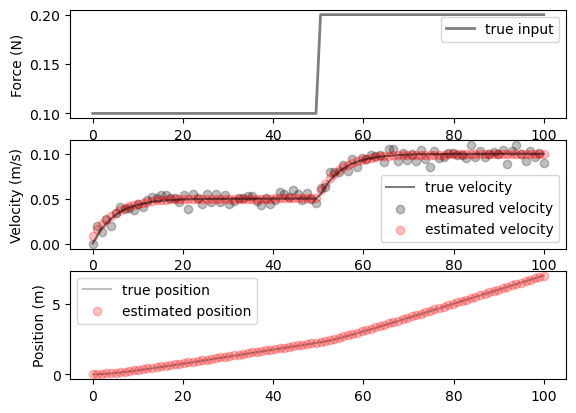

In [14]:
y = y_no_outlier
#y[20] = 0.1
#y[80] = 0.025 
u = u0

HORIZON_LENGTH = 20
DATA_LENGTH, = np.shape(y)

n_states = 2
n_inputs = 1
n_outputs = 1

# define optimization variables
x = cp.Variable((n_states,HORIZON_LENGTH), complex=False)

# covariance matrices
Q_v = 0.005*np.eye(n_outputs)
Q_w = 0.0001*np.eye(n_states)

# compute inverces
Q_v_inv = np.linalg.inv(Q_v)
Q_w_inv = np.linalg.inv(Q_w)


def cvx_MHE(y, u, xhat, Q_v_inv, Q_w_inv, HORIZON_LENGTH):
    '''Simultaneous input and state estimation (SISE) formualtion as a convex optimization problem where
    HORIZON_LENGTH: The length of the moving horizon
    y: The mesuremente vector y_{k-N},...,y_k
    xhat: Is the state estimate from previous iteration \hat{x}_{k-N-1|k-N-1}
    Q_v, Q_w: Are the measurement error and state prediction error covariance matrices.

    '''
    # define objective function
    obj = 0
    for k in range(HORIZON_LENGTH):
        if k == 0:
            obj += cp.quad_form( y[k] - C@x[:,k], Q_v_inv ) + cp.quad_form( A@xhat + B@u[k] - x[:,k] , Q_w_inv )
        else:
            obj += cp.quad_form( y[k] - C@x[:,k], Q_v_inv ) + cp.quad_form( A@x[:,k-1] + B@u[k] - x[:,k] , Q_w_inv )

    objective = cp.Minimize( obj )

    # define constraints
    constraints = []

    # define problem
    prob = cp.Problem(objective, constraints)

    # solve optimizaiton problem
    prob.solve()
    return x.value

xhat = np.zeros( (n_states,DATA_LENGTH) )
#x_est = np.array([])
for i in range( DATA_LENGTH - HORIZON_LENGTH + 1):
    #sliding horizon
    y_horizon = y[i:i+HORIZON_LENGTH].reshape(-1,1)
    u_horizon = u[i:i+HORIZON_LENGTH].reshape(-1,1)

    if i == 0:
        # first iteration use x0 as initial state estimate
        xhat_horizon = cvx_MHE(y_horizon, u_horizon, xhat[:,i], Q_v_inv, Q_w_inv, HORIZON_LENGTH)
    else:
        xhat_horizon = cvx_MHE(y_horizon, u_horizon, xhat[:,i-1], Q_v_inv, Q_w_inv, HORIZON_LENGTH)

    if i == DATA_LENGTH - HORIZON_LENGTH:
        #append the last horizon
        xhat[:,-HORIZON_LENGTH:] = xhat_horizon
    else:
        xhat[:,i] = xhat_horizon[:,0]

# plot result
fig, axs = plt.subplots(3)
axs[0].plot(t, u0,'k', alpha=0.5, linewidth=2, label='true input')
axs[0].set_ylabel('Force (N)')
axs[0].legend()
axs[1].plot(tout, xout[:,1], color='k', alpha=0.5, label='true velocity')
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None, label='measured velocity')
axs[1].scatter(t, xhat[1,:], alpha=0.25, color='r', edgecolor=None, label='estimated velocity')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
axs[2].plot(tout, xout[:,0], color='k', alpha=0.25, label='true position')
axs[2].scatter(t, xhat[0,:], alpha=0.25, color='r', edgecolor=None, label='estimated position')
axs[2].set_ylabel('Position (m)')
axs[2].legend()


### Moving-horizong input and state estimation

\begin{align*}
    &\underset{ x, u  }{\mathrm{minimize}} \quad \sum_{n=k-N}^{k} v_n^T Q_v^{-1} v_n + \sum_{n=k-N}^{k} w_n^T Q_w^{-1} w_n + \sum_{n=k-N-1}^{k-1} v_{\mathrm{u},k}^T Q_u^{-1} v_{\mathrm{u},k} \\
    &\text{subject to} \\
    &x_{n} = Ax_{n-1} + Bu_{n-1} + w_n, &n&=k-N,...,k \\
    &y_n = Cx_n + v_n, &n&=k-N,...,k \\
    &u_n = u_{n-1} + v_{\mathrm{u},k}, &n&=k-N,...,k \\
\end{align*}


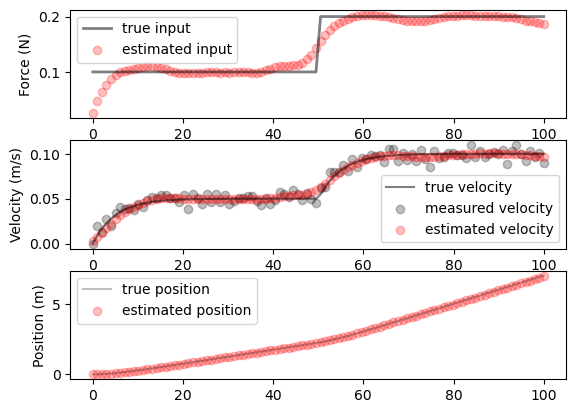

In [44]:
y = y_no_outlier
u = u0

HORIZON_LENGTH = 10
DATA_LENGTH, = np.shape(y)

n_states = 2
n_inputs = 1
n_outputs = 1

# define optimization variables
x = cp.Variable((n_states,HORIZON_LENGTH), complex=False)
u = cp.Variable((n_inputs,HORIZON_LENGTH), complex=False)
v_u = cp.Variable((n_inputs,HORIZON_LENGTH), complex=False)

# covariance matrices
Q_v = 0.005*np.eye(n_outputs)
Q_w = 0.0001*np.eye(n_states)
Q_u = 0.01*np.eye(n_inputs)

# compute inverces
Q_v_inv = np.linalg.inv(Q_v)
Q_w_inv = np.linalg.inv(Q_w)
Q_u_inv = np.linalg.inv(Q_u)

def cvx_MHE_SISE(y, xhat, uhat, Q_v_inv, Q_w_inv, Q_u_inv, HORIZON_LENGTH):
    '''Simultaneous input and state estimation (SISE) formualtion as a convex optimization problem where
    HORIZON_LENGTH: The length of the moving horizon
    y: The mesuremente vector y_{k-N},...,y_k
    xhat: Is the state estimate from previous iteration \hat{x}_{k-N-1|k-N-1}
    Q_v, Q_w: Are the measurement error and state prediction error covariance matrices.

    '''
    # define objective function
    obj = 0
    for k in range(HORIZON_LENGTH):
        if k == 0:
            obj += cp.quad_form( y[k] - C@x[:,k], Q_v_inv ) + cp.quad_form( A@xhat + B@u[:,k] - x[:,k] , Q_w_inv ) + cp.quad_form( v_u[:,k], Q_u_inv ) 
        else:
            obj += cp.quad_form( y[k] - C@x[:,k], Q_v_inv ) + cp.quad_form( A@x[:,k-1] + B@u[:,k] - x[:,k] , Q_w_inv ) + cp.quad_form( v_u[:,k], Q_u_inv )

    objective = cp.Minimize( obj )

    # define constraints
    constraints = []
    for k in range(HORIZON_LENGTH):
        if k == 0:
            constraints.append( u[:,k] == uhat + v_u[:,k] )
        else:
            constraints.append( u[:,k] == u[:,k-1] + v_u[:,k] )

    # define problem
    prob = cp.Problem(objective, constraints)

    # solve optimizaiton problem
    prob.solve()
    return x.value, u.value

#
xhat = np.zeros( (n_states,DATA_LENGTH) )
uhat = np.zeros( (n_inputs,DATA_LENGTH) )
for i in range( DATA_LENGTH - HORIZON_LENGTH + 1):
    #sliding horizon
    y_horizon = y[i:i+HORIZON_LENGTH].reshape(-1,1)

    if i == 0:
        # first iteration use x0 as initial state estimate
        xhat_horizon, uhat_horizon = cvx_MHE_SISE(y_horizon, xhat[:,i], uhat[:,i], Q_v_inv, Q_w_inv, Q_u_inv, HORIZON_LENGTH)
    else:
        xhat_horizon, uhat_horizon = cvx_MHE_SISE(y_horizon, xhat[:,i-1], uhat[:,i-1], Q_v_inv, Q_w_inv, Q_u_inv, HORIZON_LENGTH)

    if i == DATA_LENGTH - HORIZON_LENGTH:
        #append the last horizon
        xhat[:,-HORIZON_LENGTH:] = xhat_horizon
        uhat[:,-HORIZON_LENGTH:] = uhat_horizon
    else:
        xhat[:,i] = xhat_horizon[:,0]
        uhat[:,i] = uhat_horizon[:,0]

# plot result
fig, axs = plt.subplots(3)
axs[0].plot(t, u0,'k', alpha=0.5, linewidth=2, label='true input')
axs[0].scatter(t, uhat, alpha=0.25, color='r', edgecolor=None, label='estimated input')
axs[0].set_ylabel('Force (N)')
axs[0].legend()
axs[1].plot(tout, xout[:,1], color='k', alpha=0.5, label='true velocity')
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None, label='measured velocity')
axs[1].scatter(t, xhat[1,:], alpha=0.25, color='r', edgecolor=None, label='estimated velocity')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
axs[2].plot(tout, xout[:,0], color='k', alpha=0.25, label='true position')
axs[2].scatter(t, xhat[0,:], alpha=0.25, color='r', edgecolor=None, label='estimated position')
axs[2].set_ylabel('Position (m)')
axs[2].legend()

### Moving Horizon Trend Filtering

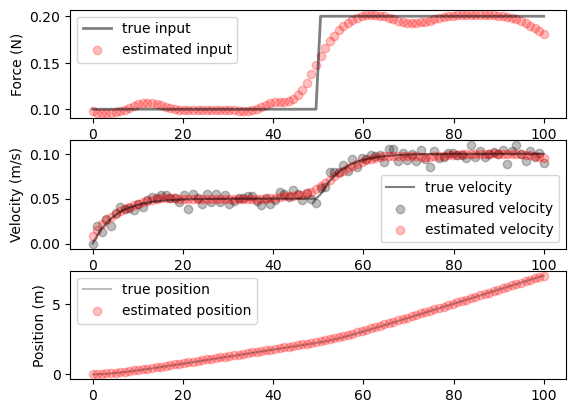

In [60]:
y = y_no_outlier
u = u0

HORIZON_LENGTH = 10
DATA_LENGTH, = np.shape(y)

n_states = 2
n_inputs = 1
n_outputs = 1

# define optimization variables
x = cp.Variable((n_states,HORIZON_LENGTH), complex=False)
u = cp.Variable((n_inputs,HORIZON_LENGTH), complex=False)
delta = cp.Variable((n_inputs,HORIZON_LENGTH), complex=False)

# covariance matrices
Q_v = 0.005*np.eye(n_outputs)
Q_w = 0.0001*np.eye(n_states)

# compute inverces
Q_v_inv = np.linalg.inv(Q_v)
Q_w_inv = np.linalg.inv(Q_w)

lambda_ = 100

def cvx_MHE_HP(y, xhat, uhat, Q_v_inv, Q_w_inv, lam, HORIZON_LENGTH):
    '''Simultaneous input and state estimation (SISE) formualtion as a convex optimization problem where
    HORIZON_LENGTH: The length of the moving horizon
    y: The mesuremente vector y_{k-N},...,y_k
    xhat: Is the state estimate from previous iteration \hat{x}_{k-N-1|k-N-1}
    Q_v, Q_w: Are the measurement error and state prediction error covariance matrices.

    '''
    # define objective function
    obj = 0
    for k in range(HORIZON_LENGTH):
        if k == 0:
            obj += cp.quad_form( y[k] - C@x[:,k], Q_v_inv ) + cp.quad_form( A@xhat + B@u[:,k] - x[:,k] , Q_w_inv )
        else:
            obj += cp.quad_form( y[k] - C@x[:,k], Q_v_inv ) + cp.quad_form( A@x[:,k-1] + B@u[:,k] - x[:,k] , Q_w_inv )
        obj += lambda_*cp.sum_squares(delta)

    objective = cp.Minimize( obj )

    # define constraints
    constraints = []
    for k in range(HORIZON_LENGTH-1):
        if k == 0:
            constraints.append( delta[:,k] == uhat - 2*u[:,k] + u[:,k+1] )
        else:
            constraints.append( delta[:,k] == u[:,k-1] - 2*u[:,k] + u[:,k+1] )

    # define problem
    prob = cp.Problem(objective, constraints)

    # solve optimizaiton problem
    prob.solve()
    return x.value, u.value

#
xhat = np.zeros( (n_states,DATA_LENGTH) )
uhat = np.zeros( (n_inputs,DATA_LENGTH) )
uhat[0] = 0.1
for i in range( DATA_LENGTH - HORIZON_LENGTH + 1):
    #sliding horizon
    y_horizon = y[i:i+HORIZON_LENGTH].reshape(-1,1)

    if i == 0:
        # first iteration use x0 as initial state estimate
        xhat_horizon, uhat_horizon = cvx_MHE_HP(y_horizon, xhat[:,i], uhat[:,i], Q_v_inv, Q_w_inv, lam, HORIZON_LENGTH)
    else:
        xhat_horizon, uhat_horizon = cvx_MHE_HP(y_horizon, xhat[:,i-1], uhat[:,i-1], Q_v_inv, Q_w_inv, lam, HORIZON_LENGTH)

    if i == DATA_LENGTH - HORIZON_LENGTH:
        #append the last horizon
        xhat[:,-HORIZON_LENGTH:] = xhat_horizon
        uhat[:,-HORIZON_LENGTH:] = uhat_horizon
    else:
        xhat[:,i] = xhat_horizon[:,0]
        uhat[:,i] = uhat_horizon[:,0]

# plot result
fig, axs = plt.subplots(3)
axs[0].plot(t, u0,'k', alpha=0.5, linewidth=2, label='true input')
axs[0].scatter(t, uhat, alpha=0.25, color='r', edgecolor=None, label='estimated input')
axs[0].set_ylabel('Force (N)')
axs[0].legend()
axs[1].plot(tout, xout[:,1], color='k', alpha=0.5, label='true velocity')
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None, label='measured velocity')
axs[1].scatter(t, xhat[1,:], alpha=0.25, color='r', edgecolor=None, label='estimated velocity')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
axs[2].plot(tout, xout[:,0], color='k', alpha=0.25, label='true position')
axs[2].scatter(t, xhat[0,:], alpha=0.25, color='r', edgecolor=None, label='estimated position')
axs[2].set_ylabel('Position (m)')
axs[2].legend()

### Moving Horizon SVR (WIP)

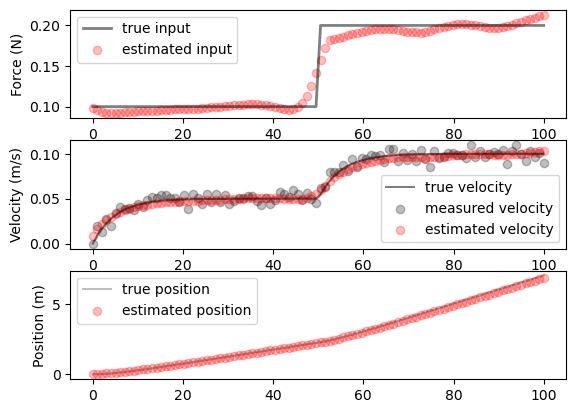

In [68]:
y = y_no_outlier
u = u0

HORIZON_LENGTH = 20
DATA_LENGTH, = np.shape(y)

n_states = 2
n_inputs = 1
n_outputs = 1

# define optimization variables
x = cp.Variable((n_states,HORIZON_LENGTH), complex=False)
u = cp.Variable((n_inputs,HORIZON_LENGTH), complex=False)
zeta = cp.Variable((n_outputs,HORIZON_LENGTH), complex=False)
zeta_ast = cp.Variable((n_outputs,HORIZON_LENGTH), complex=False)
delta = cp.Variable((n_inputs,HORIZON_LENGTH), complex=False)

# covariance matrices
Q_w = 0.0001*np.eye(n_states)

# compute inverces
Q_w_inv = np.linalg.inv(Q_w)

lambda1 = 10
lambda2 = 1
eps = 0.01

def cvx_MHE_SVR(y, xhat, uhat, Q_w_inv, lambda1, lambda2, HORIZON_LENGTH):
    '''Simultaneous input and state estimation (SISE) formualtion as a convex optimization problem where
    HORIZON_LENGTH: The length of the moving horizon
    y: The mesuremente vector y_{k-N},...,y_k
    xhat: Is the state estimate from previous iteration \hat{x}_{k-N-1|k-N-1}
    Q_v, Q_w: Are the measurement error and state prediction error covariance matrices.

    '''
    # define objective function
    obj = 0
    for k in range(HORIZON_LENGTH):
        if k == 0:
            obj += cp.quad_form( A@xhat + B@u[:,k] - x[:,k] , Q_w_inv )
        else:
            obj += cp.quad_form( A@x[:,k-1] + B@u[:,k] - x[:,k] , Q_w_inv )
        obj += lambda1*cp.sum_squares(delta) + lambda2*cp.norm(zeta + zeta_ast,1)

    objective = cp.Minimize( obj )

    # define constraints
    constraints = []
    for k in range(HORIZON_LENGTH-1):
        constraints.append( y[k] - C@x[:,k] <= eps + zeta[:,k] )
        constraints.append( - y[k] + C@x[:,k] <= eps + zeta_ast[:,k] )
        if k == 0:
            constraints.append( delta[:,k] == uhat - 2*u[:,k] + u[:,k+1] )
        else:
            constraints.append( delta[:,k] == u[:,k-1] - 2*u[:,k] + u[:,k+1] )
    constraints.append( zeta >= 0 )
    constraints.append( zeta_ast >= 0 )

    # define problem
    prob = cp.Problem(objective, constraints)

    # solve optimizaiton problem
    prob.solve()
    return x.value, u.value

#
xhat = np.zeros( (n_states,DATA_LENGTH) )
uhat = np.zeros( (n_inputs,DATA_LENGTH) )
uhat[0] = 0.1
for i in range( DATA_LENGTH - HORIZON_LENGTH + 1):
    #sliding horizon
    y_horizon = y[i:i+HORIZON_LENGTH].reshape(-1,1)

    if i == 0:
        # first iteration use x0 as initial state estimate
        xhat_horizon, uhat_horizon = cvx_MHE_SVR(y_horizon, xhat[:,i], uhat[:,i], Q_w_inv, lambda1, lambda2, HORIZON_LENGTH)
    else:
        xhat_horizon, uhat_horizon = cvx_MHE_SVR(y_horizon, xhat[:,i-1], uhat[:,i-1], Q_w_inv, lambda1, lambda2, HORIZON_LENGTH)

    if i == DATA_LENGTH - HORIZON_LENGTH:
        #append the last horizon
        xhat[:,-HORIZON_LENGTH:] = xhat_horizon
        uhat[:,-HORIZON_LENGTH:] = uhat_horizon
    else:
        xhat[:,i] = xhat_horizon[:,0]
        uhat[:,i] = uhat_horizon[:,0]

# plot result
fig, axs = plt.subplots(3)
axs[0].plot(t, u0,'k', alpha=0.5, linewidth=2, label='true input')
axs[0].scatter(t, uhat, alpha=0.25, color='r', edgecolor=None, label='estimated input')
axs[0].set_ylabel('Force (N)')
axs[0].legend()
axs[1].plot(tout, xout[:,1], color='k', alpha=0.5, label='true velocity')
axs[1].scatter(tout, y, alpha=0.25, color='k', edgecolor=None, label='measured velocity')
axs[1].scatter(t, xhat[1,:], alpha=0.25, color='r', edgecolor=None, label='estimated velocity')
axs[1].set_ylabel('Velocity (m/s)')
axs[1].legend()
axs[2].plot(tout, xout[:,0], color='k', alpha=0.25, label='true position')
axs[2].scatter(t, xhat[0,:], alpha=0.25, color='r', edgecolor=None, label='estimated position')
axs[2].set_ylabel('Position (m)')
axs[2].legend()